In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.svm import SVR

In [2]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':100})
start_time = time()

energy_meters_df = pd.read_excel('data/VIS Målere.xlsx')
# Remove leading and trailing whitespace in cells with value of type string
energy_meters_df = energy_meters_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

raw_esave_tables_dict = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', decimal=',', sheet_name=None)
raw_esave_tables_list = raw_esave_tables_dict.values()
for table in raw_esave_tables_list:
    table.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    table['datetime'] = pd.to_datetime(table['datetime'], dayfirst=True)
    table.set_index('datetime', inplace=True)
    table.sort_index()
raw_esave_table = pd.concat(raw_esave_tables_list, axis=1, ignore_index=False)

stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to read xls files')

Used 87.89 seconds to read xls files


In [3]:
start_time = time()

buildings = {}
current_building = None
sensor_types = ['Fastkraft', 'Fjernvarme', 'Varme', 'Elkjel', 'Kjøling']
for _, row in energy_meters_df.iterrows():
    # if current row is a building not a sensor create a new dict to store all sensors for that building
    if row['Objekt'] == 'Bygg':
        current_building = {}
        for sensor_type in sensor_types:
            current_building[sensor_type] = {}
        buildings[row['Navn']] = current_building
        continue
    
    sensor_type = row['Type']
    if sensor_type in sensor_types:
        name = row['Navn']
        sensor_id = row['Formel']
        current_building[sensor_type][name] = sensor_id


stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to parse')

Used 0.05 seconds to parse


In [4]:
# Create a dictionary that contains a dataframe for each building that have column for each sensor type (e.g. Fjernvarme or Fastkraft)
building_dfs = {}
for building_name, sensor_type_dict in buildings.items():

    sensor_type_series = {}
    for sensor_type, sensor_dict in sensor_type_dict.items():
        for sensor_id in sensor_dict.values():
            if sensor_id in raw_esave_table.columns:
                sensor_series = raw_esave_table[sensor_id]
                if not sensor_type in sensor_type_series:
                    sensor_type_series[sensor_type] = sensor_series
                else:
                    sensor_type_series[sensor_type] = sensor_type_series[sensor_type] + sensor_series
    if sensor_type_series:
        df = pd.DataFrame(sensor_type_series)
        df.sort_index(inplace=True)
        df.dropna(axis='index')
        building_dfs[building_name] = df

# Create a column in each building dataframe that is the total energy consumption, i.e. the sum of all other columns.
for building_df in building_dfs.values():
    building_df['Totalt'] = building_df[list(building_df.columns)].sum(axis=1)

In [5]:
# Create new data frames for each building that have values for each day or week instead of hourly
building_daily_dfs = {}
building_weekly_dfs = {}
for building_name, building_df in building_dfs.items():
    building_daily_dfs[building_name] = building_df.resample('D').sum()
    building_weekly_dfs[building_name] = building_df.resample('W-MON').sum()

In [6]:
for building_name, weekly_consumption_dict in building_weekly_dfs.items():
    if weekly_consumption_dict['Totalt'].isnull().values.any():
        print(f'{building_name} have null values')

    if weekly_consumption_dict['Totalt'].isna().values.any():
        print(f'{building_name} have nan values')

In [7]:
temp_voll = raw_esave_table['Eklima_68860_TAM']
temp_voll_weekly_mean = temp_voll.resample('W-MON').mean()
temp_voll_daily_mean = temp_voll.resample('D').mean()

In [8]:
def generate_et_curve1(energy_consumption_series: pd.Series, temperature_series: pd.Series):
    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    X = df['temperature'].values.reshape(df.shape[0], 1)
    y = df['energy'].values.reshape(df.shape[0], 1)

    model = SVR(kernel='rbf', C=5000)
    # model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X, y)

    plt.scatter(X, y,  color='black')
    plt.plot(X, model.predict(X), color='blue', linewidth=3)
    plt.show()

    return model


In [9]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy
        # round to 2 decimal places
        self.dx = [round(x, 2) for x in self.dx]
        self.dy = [round(x, 2) for x in self.dy]

    def expected(self, temperature):
        if temperature < self.dx[0]:
            # print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            # print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = energy_series / expected_series >= (threshold + 1)
        return energy_series[mask]

    def plot(self, energy_series, temperature_series):
        plt.plot(self.dx, self.dy, color='red', linewidth=3)
        plt.scatter(temperature_series, energy_series)
        plt.show()

In [10]:
def generate_et_curve2(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = LinearRegression()
        model.fit(X_seg, y_seg)

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    if plot:
        plt.plot(dx, dy, color='red', linewidth=3)
        plt.scatter(X, y)
        plt.show()

    return et_curve(dx, dy)

In [11]:
def generate_et_curve3(energy_consumption_series: pd.Series, temperature_series: pd.Series, points_per_segment, plot: bool = False):

    # ensure that we match values for energy and temp, and that there are no nan values.
    energy_consumption_series.rename('energy', inplace=True)
    temperature_series.rename('temperature', inplace=True)
    df = pd.concat((energy_consumption_series, temperature_series), axis=1, ignore_index=False)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='temperature', inplace=True)

    number_of_points = df.shape[0]

    X = df['temperature'].values.reshape(number_of_points, 1)
    y = df['energy'].values.reshape(number_of_points, 1)

    dx = []
    dy = []

    for i in range(0, number_of_points + 1, points_per_segment):
        n = min(points_per_segment, number_of_points - i)

        X_seg = X[i:i+n, :]
        y_seg = y[i:i+n, :]

        model = RANSACRegressor()
        try:
            model.fit(X_seg, y_seg)
        except:
            # TODO: if we end up using RANSACRegressor we must add some error handling that uses more points for segment if it fails to fit for number of points initially given
            continue

        if i == 0:
            X_first = X_seg[0].reshape(1,1)
            y_first = model.predict(X_first)
            dx.append(X_first[0,0])
            dy.append(y_first[0,0])

        X_middle = X_seg[n//2].reshape(1,1)
        y_middle = model.predict(X_middle)
        dx.append(X_middle[0,0])
        dy.append(y_middle[0,0])

        if i >= number_of_points - points_per_segment:
            X_last = X_seg[-1].reshape(1,1)
            y_last = model.predict(X_last)
            dx.append(X_last[0,0])
            dy.append(y_last[0,0])

    if plot:
        plt.plot(dx, dy, color='red', linewidth=3)
        plt.scatter(X, y)
        plt.show()
        
    return et_curve(dx, dy)


In [12]:
test_building_name = 'Trondheim Kommune - Lilleby skole'

et_reg = generate_et_curve3(building_weekly_dfs[test_building_name]['Totalt'], temp_voll_weekly_mean, 40)

et_reg

Trondheim Kommune - General Wibes veg 1


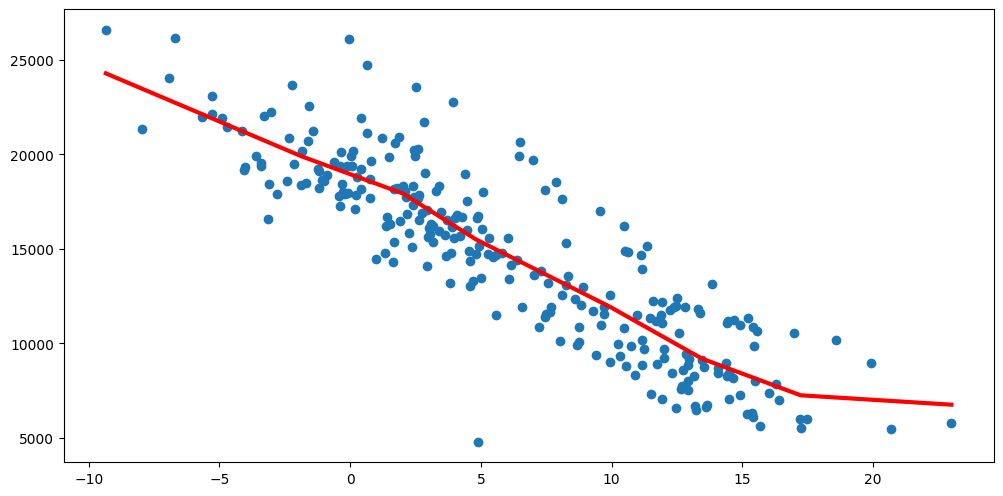

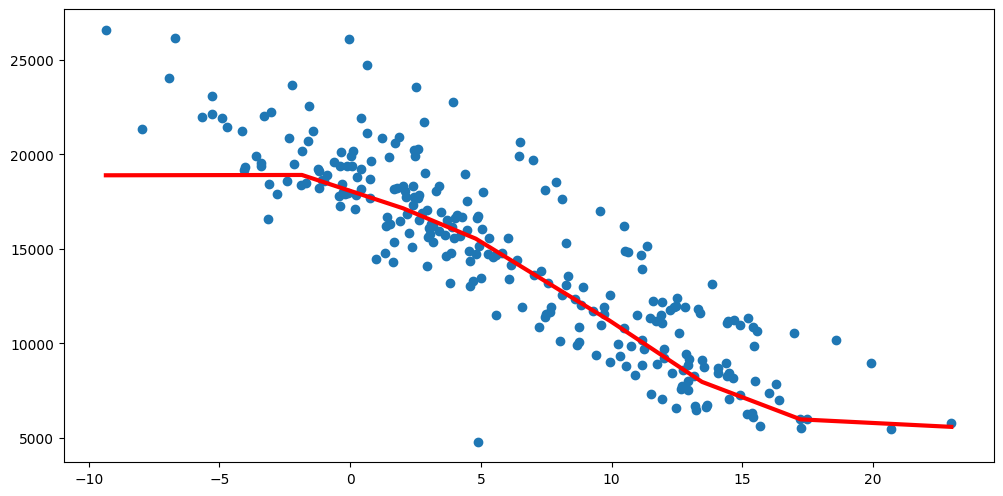

Trondheim Kommune - Spongdal skole og Byneshallen


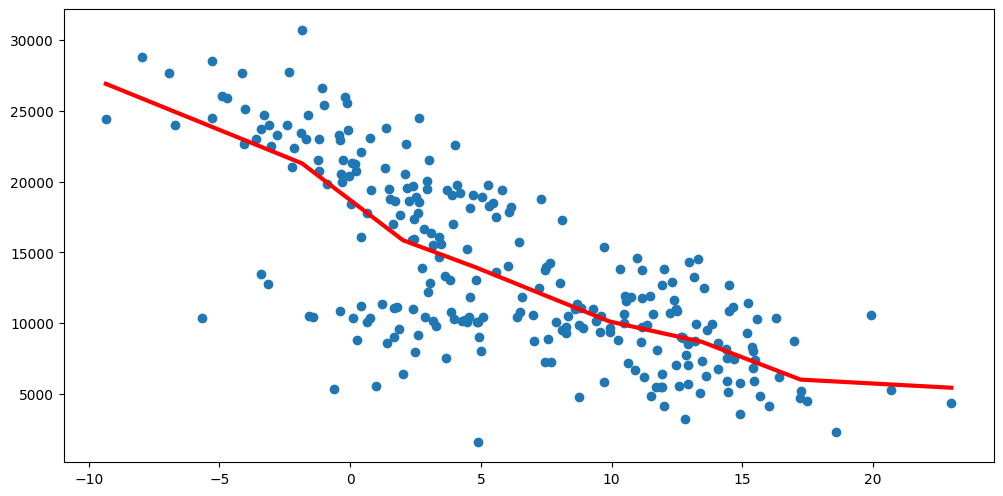

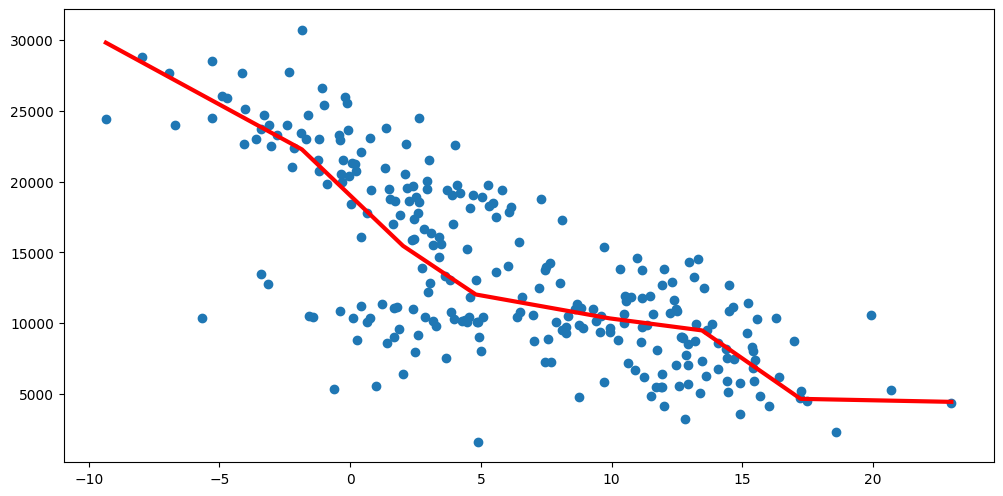

Trondheim Kommune - Ladesletta helse- og velferdssenter


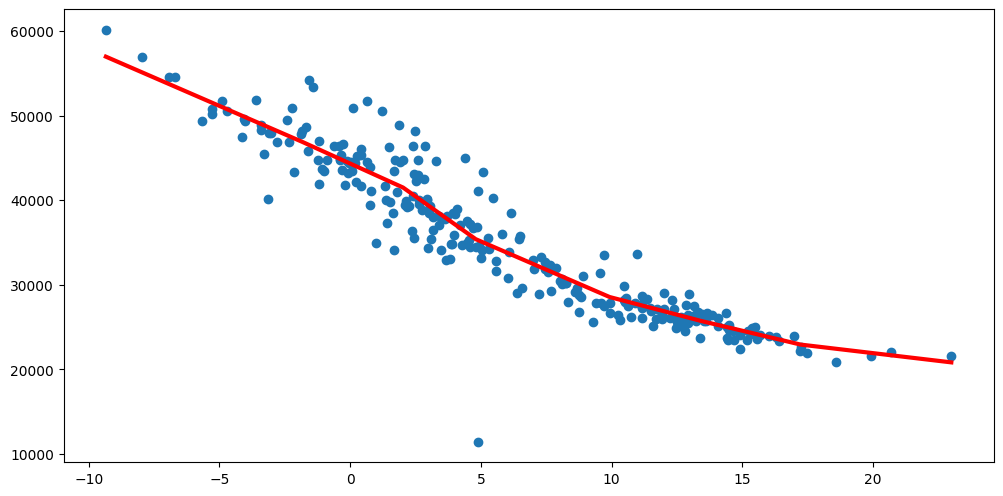

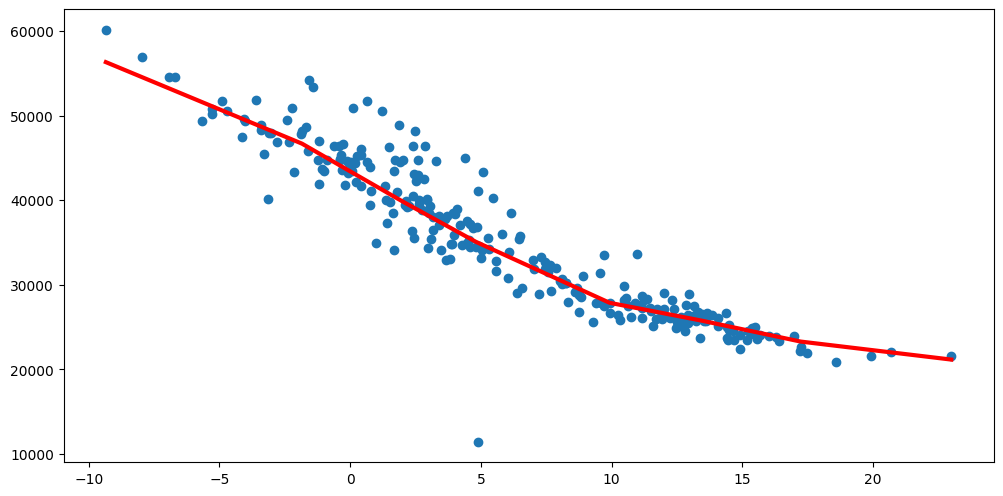

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\l

In [13]:
i = 0

et_curves_dict = {}
for name, weekly_consumption in building_weekly_dfs.items():
    i += 1

    num_to_plot = 4
    if i < num_to_plot:
        print(name)

    building_et_curve1 = generate_et_curve2(weekly_consumption['Totalt'], temp_voll_weekly_mean, 50, i < num_to_plot)
    building_et_curve2 = generate_et_curve3(weekly_consumption['Totalt'], temp_voll_weekly_mean, 50, i < num_to_plot)
    et_curves_dict[building_name] = building_et_curve1

In [14]:
building_day_of_week_dfs = {}
for building_name in building_dfs.keys():
    day_of_week_dict = {}
    building_day_of_week_dfs[building_name] = day_of_week_dict
    for i in range(7):
        day_of_week_dict[i] = building_daily_dfs[building_name].iloc[building_daily_dfs[building_name].index.dayofweek == i]

Trondheim Kommune - General Wibes veg 1
Monday


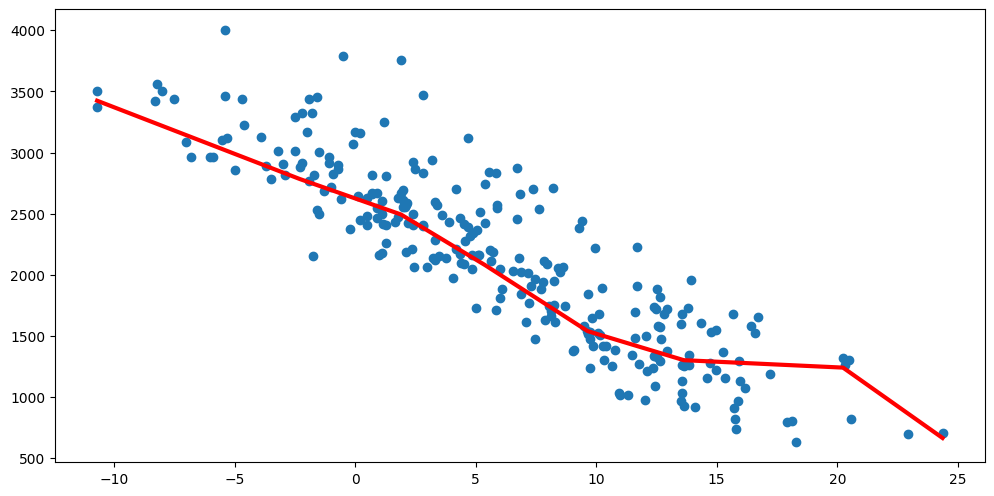

Tuesday


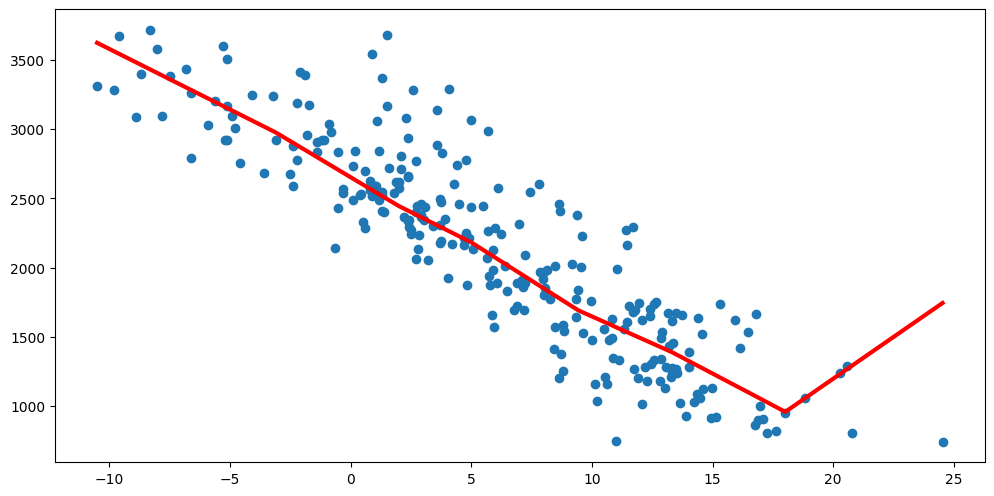

Wednesday


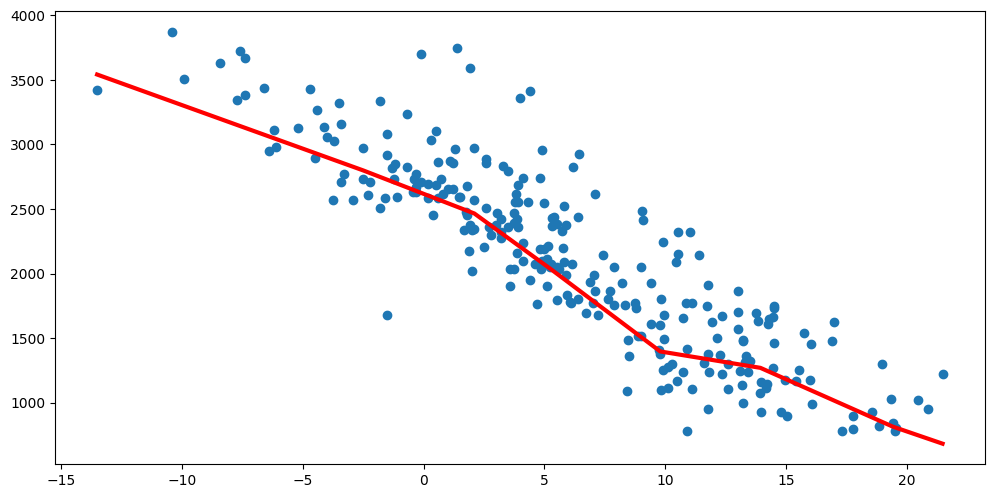

Thursday


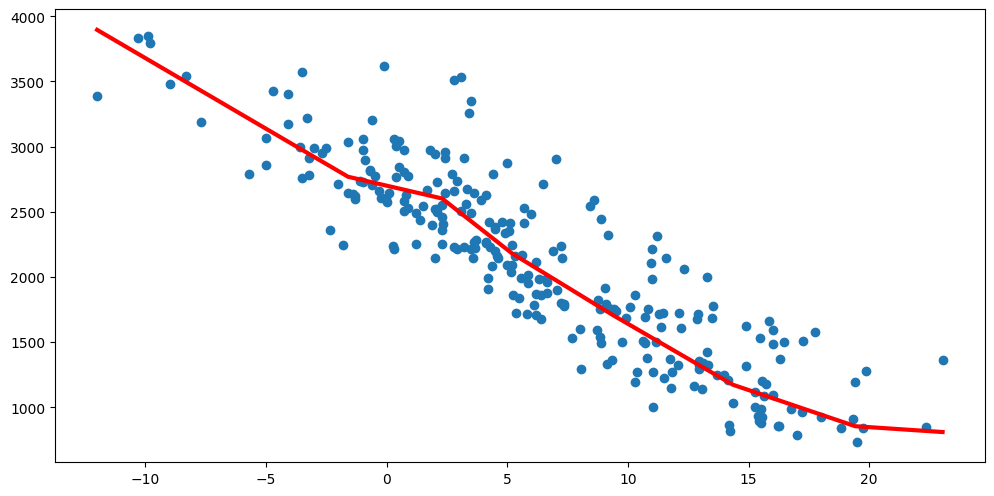

Friday


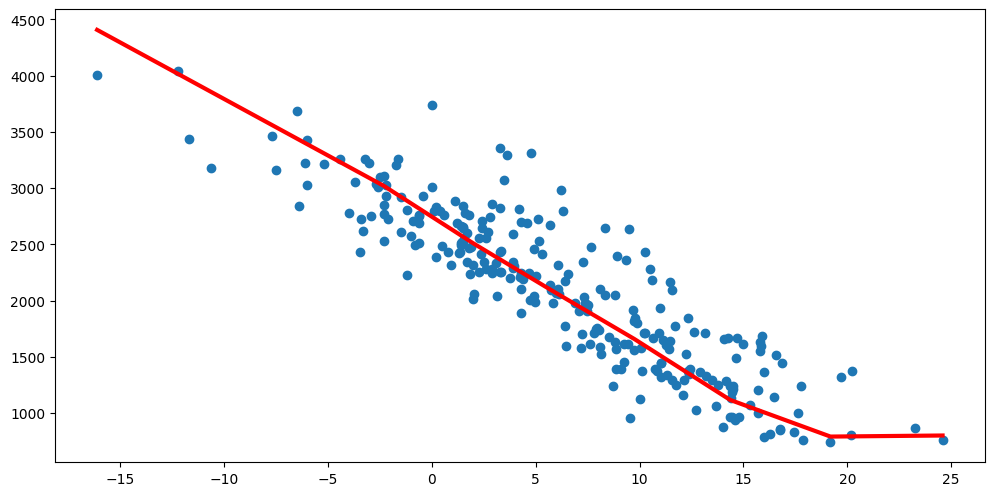

Saturday


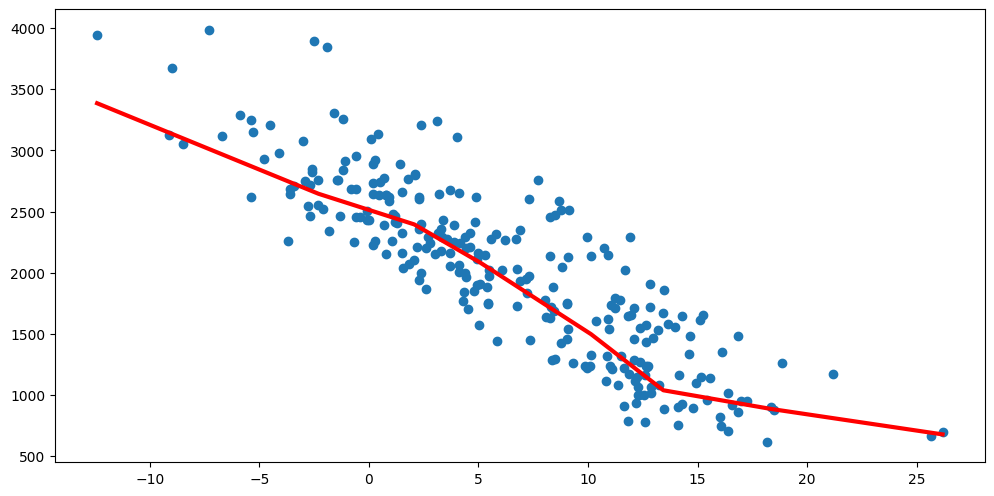

Sunday


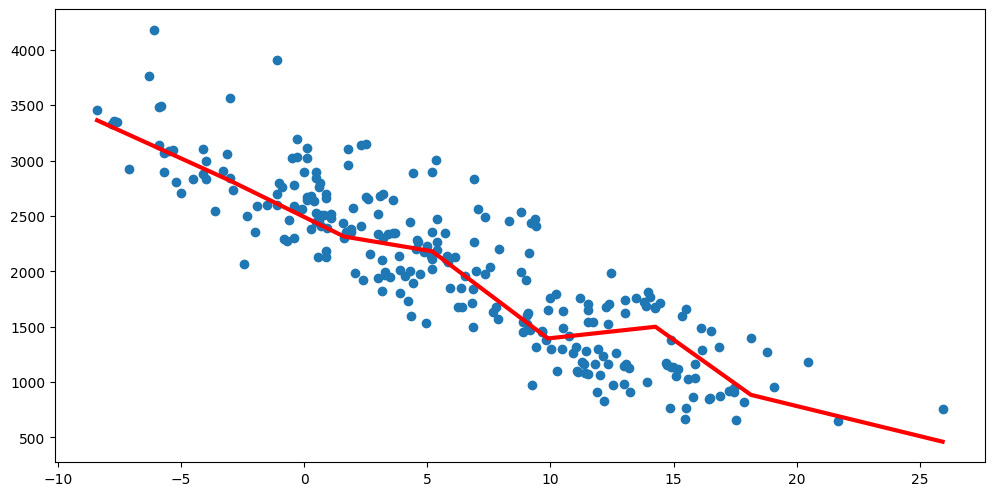

Trondheim Kommune - Spongdal skole og Byneshallen
Monday


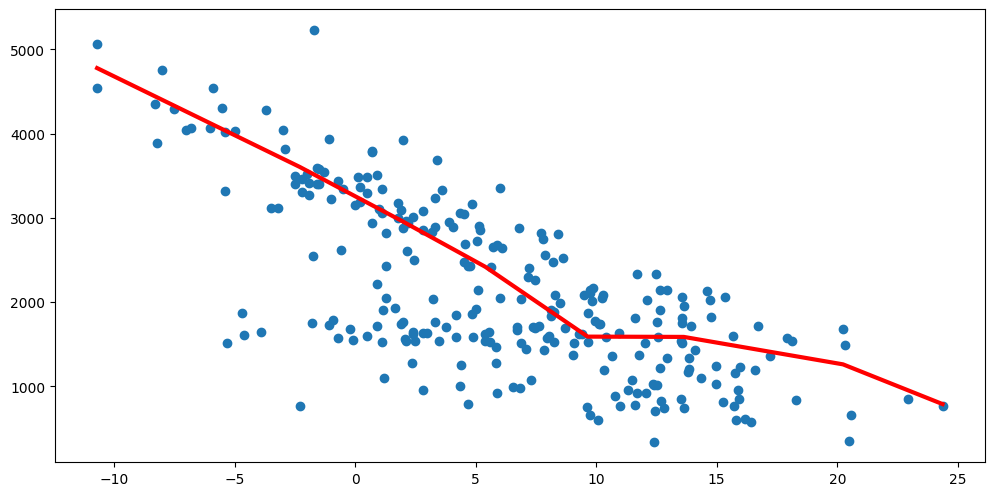

Tuesday


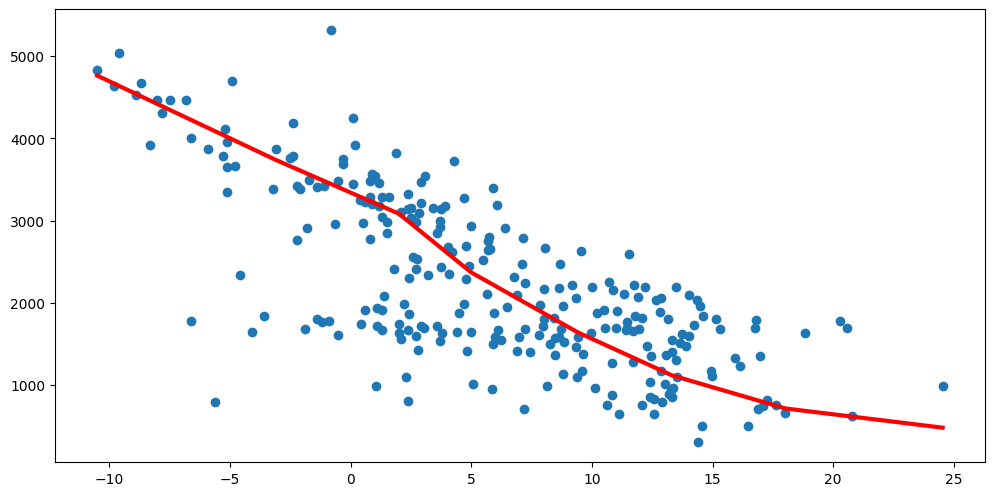

Wednesday


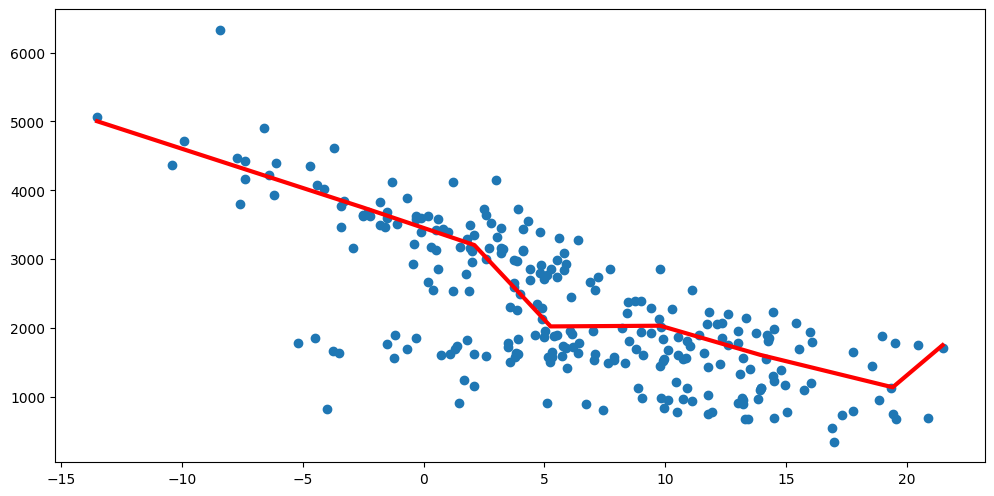

Thursday


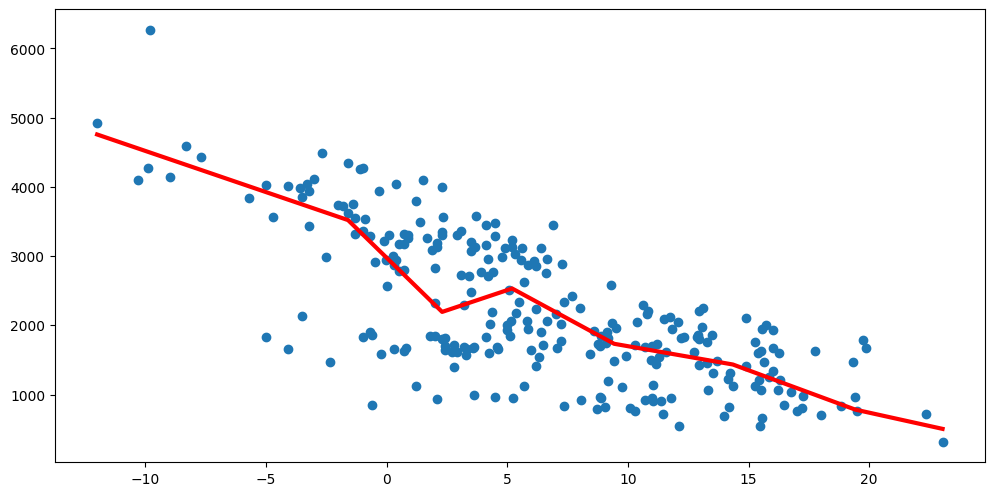

Friday


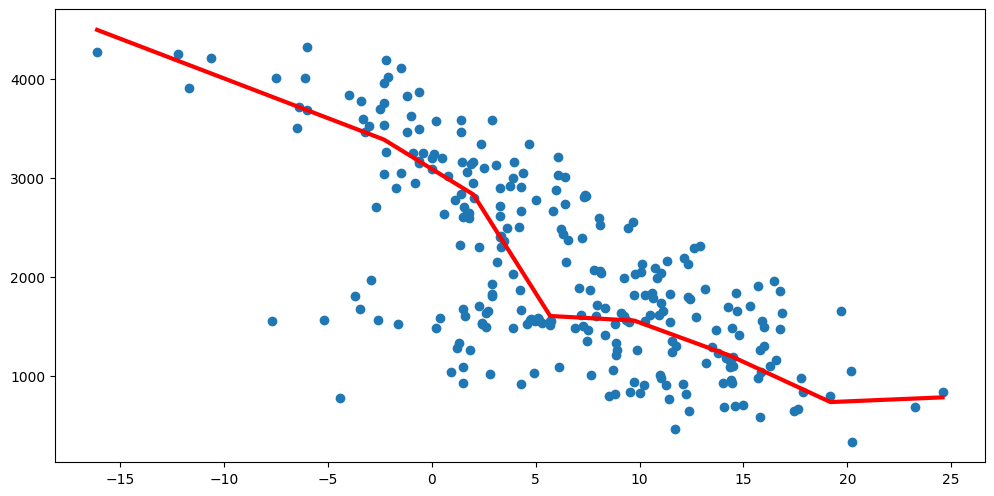

Saturday


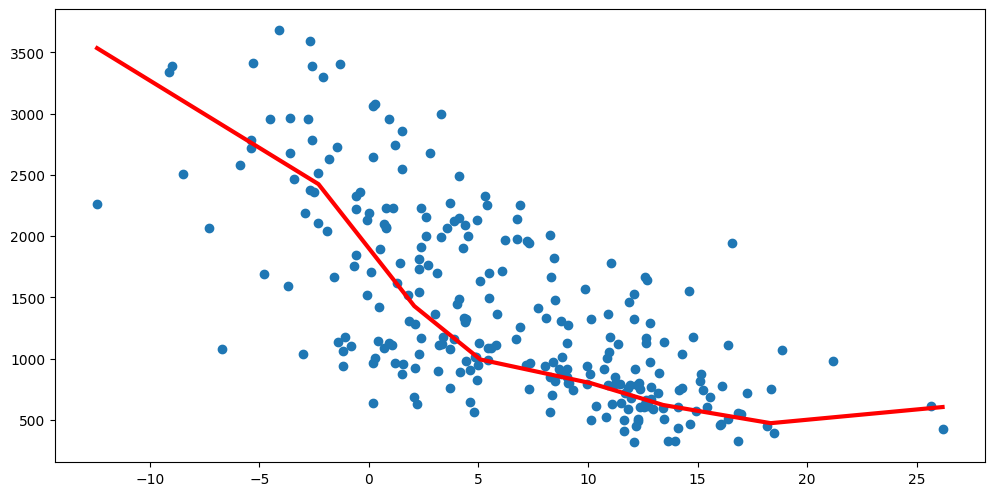

Sunday


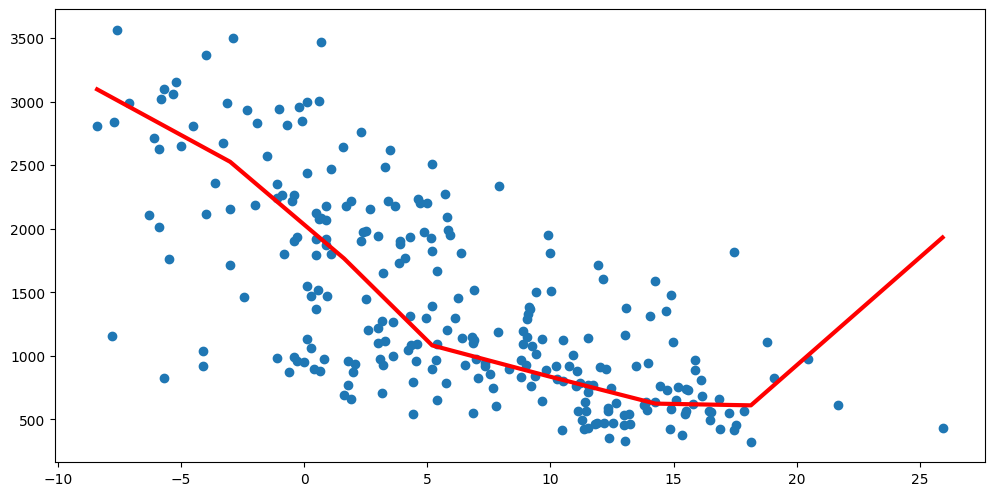

Trondheim Kommune - Ladesletta helse- og velferdssenter
Monday


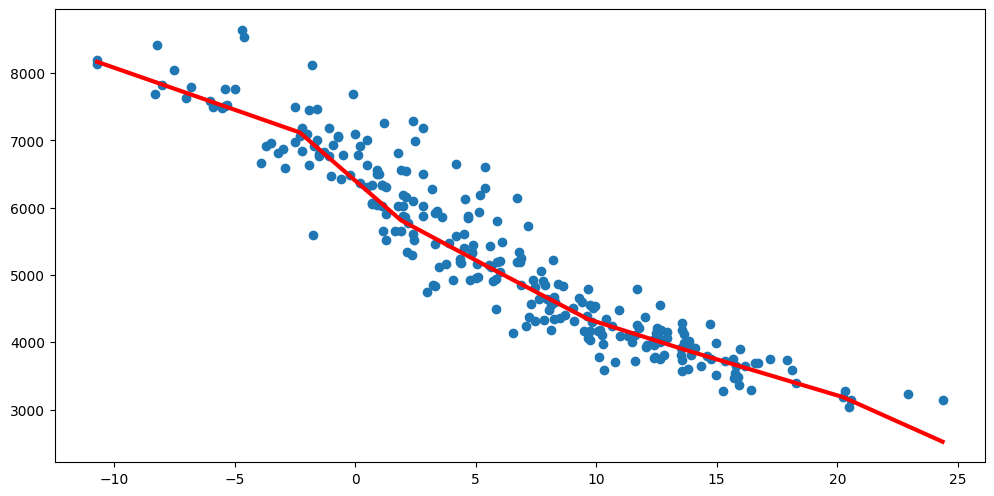

Tuesday


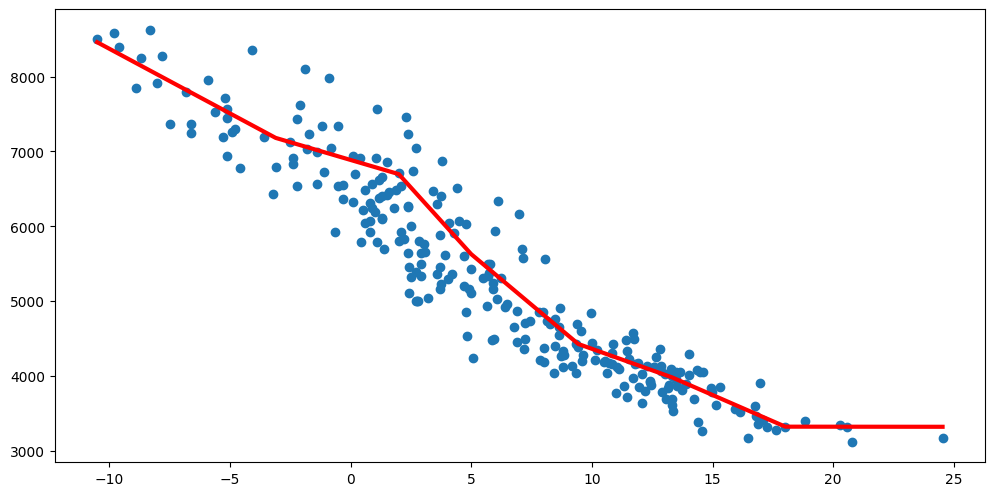

Wednesday


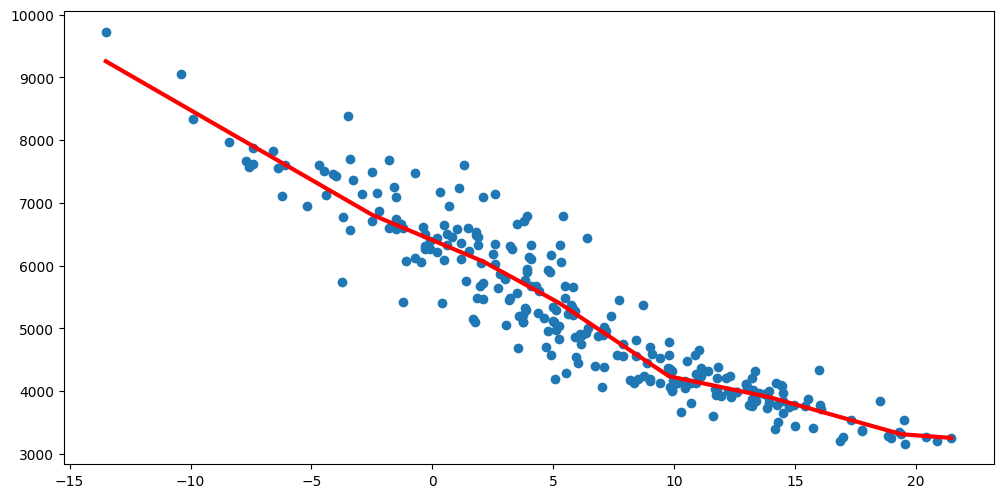

Thursday


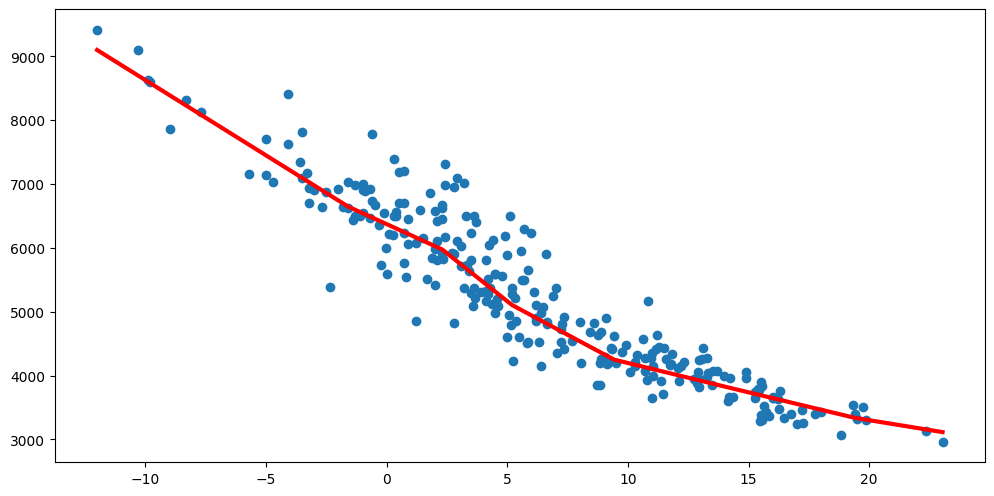

Friday


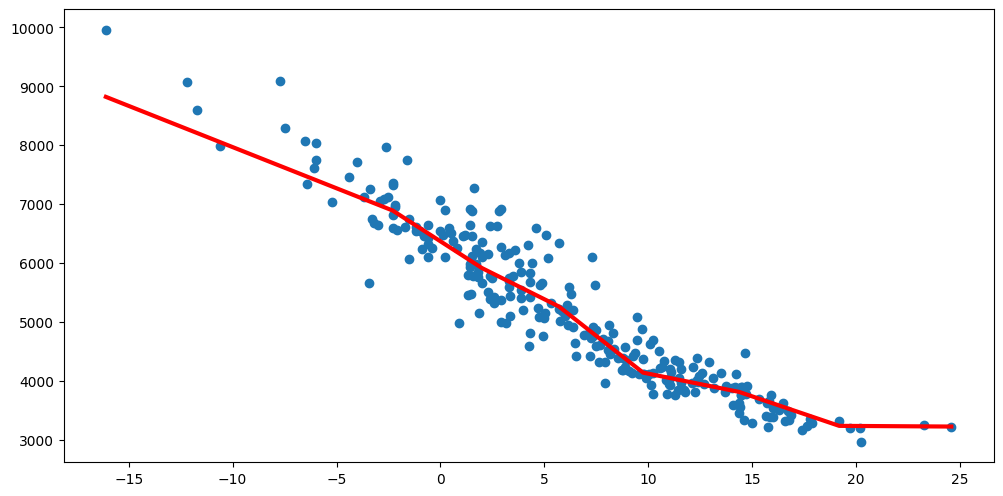

Saturday


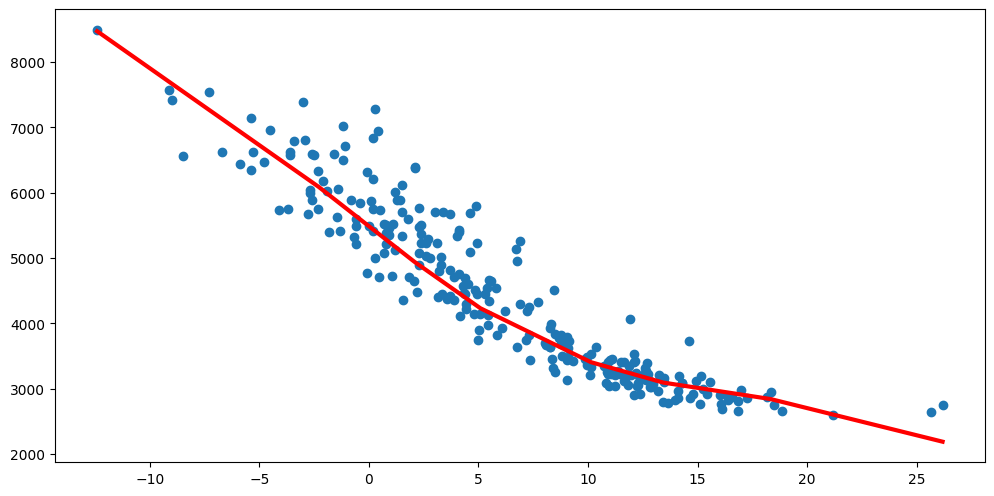

Sunday


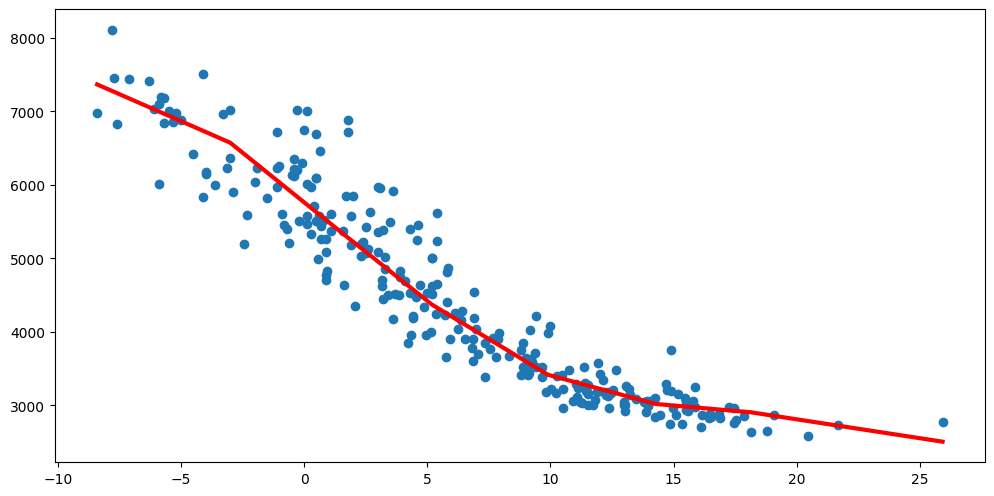

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\l

In [15]:
week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

i = 0
et_curves_building_day_of_week = {}
for name, day_of_week_dfs in building_day_of_week_dfs.items():

    i += 1
    num_to_plot = 4
    if i < num_to_plot:
        print(name)

    et_curves_building_day_of_week[name] = {}

    for day_of_week, consumption_df in day_of_week_dfs.items():
        if i < num_to_plot:
            print(week_days[day_of_week])
        building_et_curve1 = generate_et_curve3(consumption_df['Totalt'], temp_voll_daily_mean, 50, i < num_to_plot)
        # building_et_curve2 = generate_et_curve3(consumption_df['Totalt'], temp_voll_daily_mean, 50, i < num_to_plot)
        et_curves_building_day_of_week[name][day_of_week] = building_et_curve1

Trondheim Kommune - Angelltrøa barnehage <__main__.et_curve object at 0x000001A094FD3610>


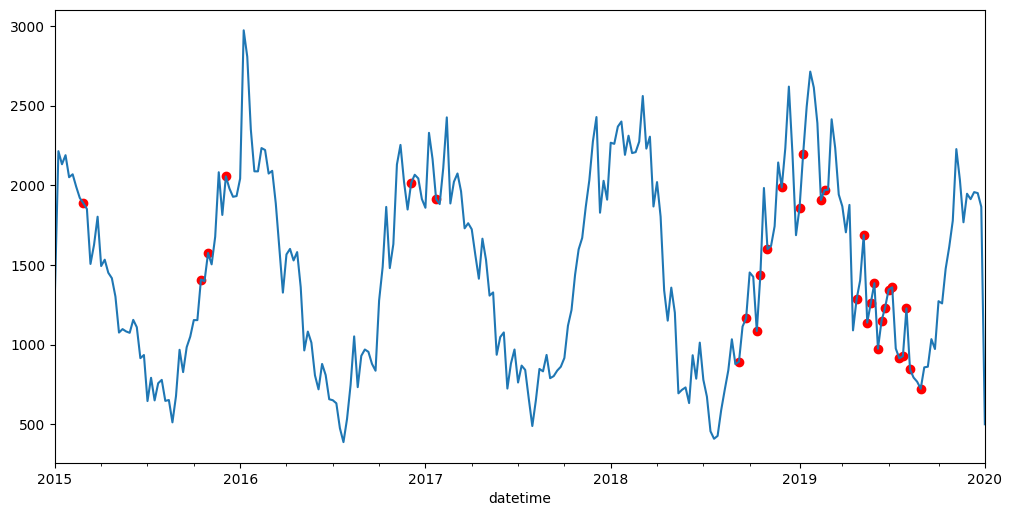

In [16]:
# get a model/ET-curve
building_name, model = list(et_curves_dict.items())[0]
print(building_name, model)
# find anomalies in the model
energy_series = building_weekly_dfs[building_name]['Totalt']
anomalies = model.get_anomolies_series(energy_series, temp_voll_weekly_mean, 0.1)
energy_series.plot()
# scatter plot the anomalies
plt.scatter(anomalies.index, anomalies.values, color='red')
# plot the ET curve
model.plot(energy_series, temp_voll_weekly_mean)
plt.show()

Trondheim Kommune - Angelltrøa barnehage [-9.34, -1.84, 2.02, 4.81, 9.92, 13.46, 17.23, 22.99] [2826.23, 2204.6, 1876.6, 1529.19, 1038.14, 818.99, 594.22, 612.29]


Text(0.02, 0.5, 'Energy (kWh)')

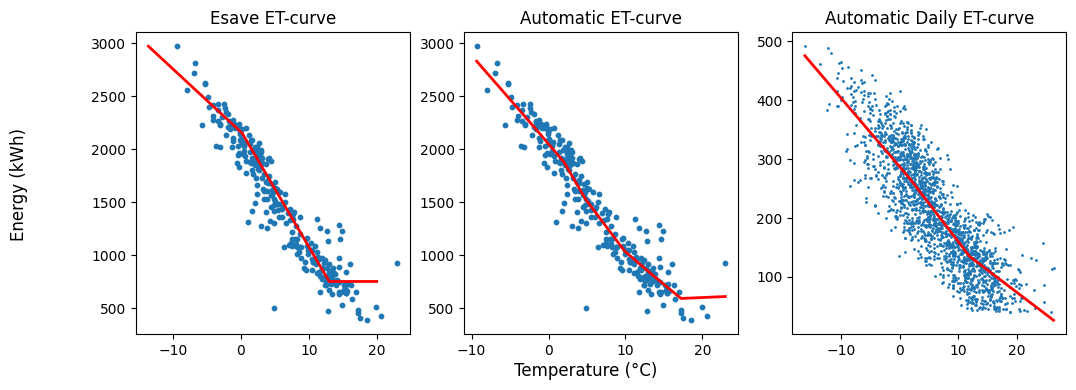

In [17]:
# plot first et curve
building_name, model = list(et_curves_dict.items())[0]
# [-9.342857142857143, 14.079166666666667, 22.99404761904762] [2938.3453717316424, 785.9782037787904, 465.3777628245564]
# get energy for that building
energy_series = building_weekly_dfs[building_name]['Totalt']
# esaves curve
esave_dx = [-13.6, 0.2, 13, 20]
esave_dy = [2967, 2149.1, 754, 754]
esave_curve = et_curve(esave_dx, esave_dy)

print(building_name, model.dx, model.dy)

# plot first et curve with daily data
daily_energy = building_daily_dfs[building_name]['Totalt']
# create et curve
daily_et = generate_et_curve2(daily_energy, temp_voll_daily_mean, 1000, False)

# create subplot with 3 plots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(esave_curve.dx, esave_curve.dy, color='red', linewidth=2)
ax[0].scatter(temp_voll_weekly_mean, energy_series, s=10)
ax[0].set_title('Esave ET-curve')

ax[1].plot(model.dx, model.dy, color='red', linewidth=2)
ax[1].scatter(temp_voll_weekly_mean, energy_series, s=10)
ax[1].set_title('Automatic ET-curve')

ax[2].plot(daily_et.dx, daily_et.dy, color='red', linewidth=2)
ax[2].scatter(temp_voll_daily_mean, daily_energy, s=1)
ax[2].set_title('Automatic Daily ET-curve')

# set labels
fig.supxlabel('Temperature (°C)')
fig.supylabel('Energy (kWh)')

In [18]:
# this cell is for validation, see validation notebook
validation_buildings = ['Trondheim Kommune - Aastahagen barnehage', 'Trondheim Kommune - Charlottenlund ungdomsskole', 'Trondheim Kommune - Dalgård Idrettsanlegg', 'Trondheim Kommune - Kystad sykehjem']
for building_name in validation_buildings:
    energy_series = building_weekly_dfs[building_name]['Totalt']
    et = generate_et_curve2(energy_series, temp_voll_weekly_mean, 500, False)
    print("weekly:", building_name, et.dx,",", et.dy)

print()

for building_name in validation_buildings:
    energy_series = building_daily_dfs[building_name]['Totalt']
    et = generate_et_curve2(energy_series, temp_voll_daily_mean, 1000, False)
    print("daily:", building_name, et.dx,",", et.dy)

weekly: Trondheim Kommune - Aastahagen barnehage [-9.34, 5.06, 22.99] , [7003.77, 3434.77, -1010.7]
weekly: Trondheim Kommune - Charlottenlund ungdomsskole [-9.34, 5.06, 22.99] , [23458.33, 11819.27, -2678.11]
weekly: Trondheim Kommune - Dalgård Idrettsanlegg [-9.34, 5.06, 22.99] , [7335.59, 4110.04, 92.36]
weekly: Trondheim Kommune - Kystad sykehjem [-9.34, 5.06, 22.99] , [16824.4, 10040.17, 1589.87]

daily: Trondheim Kommune - Aastahagen barnehage [-16.1, 1.8, 11.91, 26.18] , [1414.81, 600.74, 241.35, 74.31]
daily: Trondheim Kommune - Charlottenlund ungdomsskole [-16.1, 1.8, 11.91, 26.18] , [4369.26, 2065.32, 881.01, 5.08]
daily: Trondheim Kommune - Dalgård Idrettsanlegg [-16.1, 1.8, 11.91, 26.18] , [1095.31, 708.95, 357.84, 70.66]
daily: Trondheim Kommune - Kystad sykehjem [-16.1, 1.8, 11.91, 26.18] , [2835.74, 1677.18, 952.13, 319.45]
